<a href="https://colab.research.google.com/github/muhammad-mobeen/Sar-e-Aam-Fake-News-Detector/blob/main/Sar_e_Aam_Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attatch Google Drive

In [ ]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Sar-e-Aam-Fake-News-Detector

<h1 align="center">BERT: Fake News Detection</h1>

### Initialize Dependencies

In [ ]:
# !pip install numpy --upgrade
# !pip install -U tensorflow==2.12.*
!pip install -U tensorflow-text==2.12.*
!pip install -q -U tf-models-official==2.12.*
# !pip install -q tf-nightly

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
print(tf.__version__)

### Connect to TPU

In [ ]:
import os

print("Tensorflow version " + tf.__version__)
try: 
  if os.environ['COLAB_TPU_ADDR']:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)
    os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
    print('Using TPU')
except Exception as e:
  print("No TPU:",e)
  if tf.config.list_physical_devices('GPU'):
    tpu_strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
  else:
    raise ValueError('Running on CPU is not recommended.')

### Visiualize Dataset

In [ ]:
df_true = pd.read_csv("dataset/True.csv")
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fake = pd.read_csv("dataset/Fake.csv")
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Add another coloumn that contains binary values if news is fake or not

In [ ]:
df_true['fake'] = [0 for x in range(df_true.shape[0])]
print(df_true.shape)
df_true.head(5)

(21417, 5)


,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df_fake['fake'] = [1 for x in range(df_fake.shape[0])]
print(df_fake.shape)
df_fake.head(5)

(23481, 5)


,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


### Check if Dataset is Unbalanced

In [ ]:
print(df_true.shape)
print(df_fake.shape)

(21417, 5)
(23481, 5)


### Downsample the Un-Balanced Dataset

In [ ]:
df_fake_downsampled = df_fake.sample(df_true.shape[0])
df_fake_downsampled.shape

(21417, 5)

### Concatenate the both Fake and True Balanced Dataset into Single Dataframe

In [ ]:
# df_dataset = pd.concat([df_fake_downsampled, df_true])
df_dataset = pd.concat([df_fake, df_true])
df_dataset.shape

(44898, 5)

In [ ]:
df_dataset.head(5)

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


### Dataset Splitting into Train and Test

In [ ]:
!pip install numpy --upgrade

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_dataset['title'],df_dataset['fake'], stratify=df_dataset['fake'], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
print("Trainig Dataset:   ",X_train.shape)
print("Validation Dataset:",X_val.shape)
print("Testing Dataset:   ",X_test.shape)

Trainig Dataset:    (28734,)
Validation Dataset: (7184,)
Testing Dataset:    (8980,)


In [ ]:
y_train.head(5)

21870    1
2530     1
20840    1
14602    0
3992     1
Name: fake, dtype: int64

### Import BERT Model

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.8884575 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964495],
       [-0.87208366, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

### Building the Model

In [ ]:
EPOCHS = 10
batch_size = 32 * tpu_strategy.num_replicas_in_sync
init_lr = 2e-5

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  try:
    if bert_preprocess and bert_encoder:
      print("No need to import BERT Preprocessor and Encoder")
  except:
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

  # Training Dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
  # steps_per_epoch = X_train.shape[0] // batch_size
  steps_per_epoch = train_dataset.cardinality().numpy()
  num_train_steps = steps_per_epoch * EPOCHS
  num_warmup_steps = num_train_steps // 10

  # Validation Dataset
  validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  validation_dataset = validation_dataset.shuffle(buffer_size=1024).batch(batch_size)
  validation_steps = X_val.shape[0] // batch_size

  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])

  METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
  ]

  # Optimizer
  optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=METRICS)

No need to import BERT Preprocessor and Encoder


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
train_dataset.cardinality().numpy()

898

In [ ]:
validation_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=225>

In [ ]:
X_val.shape[0] // batch_size

224

In [ ]:
X_val.shape

(7184,)

In [ ]:
print("Steps Per Epoch:",steps_per_epoch)
print("Training Steps for Optimizer:",num_train_steps)
print("Warmup Steps for Optimizer:",num_warmup_steps)
print("Validation Steps:",validation_steps)

Steps Per Epoch: 898
Training Steps for Optimizer: 8980
Warmup Steps for Optimizer: 898
Validation Steps: 224


In [ ]:
with tpu_strategy.scope():
  model.fit(
      x= train_dataset,
      validation_data= validation_dataset,
      steps_per_epoch= steps_per_epoch,
      epochs= EPOCHS,
      validation_steps=validation_steps
      )

Epoch 1/10
898/898 [==============================] - 375s 415ms/step - loss: 0.7196 - accuracy: 0.4805 - precision: 0.5051 - recall: 0.3343 - val_loss: 0.6523 - val_accuracy: 0.6498 - val_precision: 0.6966 - val_recall: 0.5859
Epoch 2/10
898/898 [==============================] - 377s 420ms/step - loss: 0.6238 - accuracy: 0.6560 - precision: 0.6832 - recall: 0.6381 - val_loss: 0.5942 - val_accuracy: 0.6917 - val_precision: 0.7243 - val_recall: 0.6633
Epoch 3/10
898/898 [==============================] - 378s 421ms/step - loss: 0.5821 - accuracy: 0.6957 - precision: 0.7178 - recall: 0.6891 - val_loss: 0.5679 - val_accuracy: 0.7139 - val_precision: 0.7402 - val_recall: 0.6978
Epoch 4/10
898/898 [==============================] - 378s 421ms/step - loss: 0.5600 - accuracy: 0.7195 - precision: 0.7366 - recall: 0.7217 - val_loss: 0.5496 - val_accuracy: 0.7307 - val_precision: 0.7502 - val_recall: 0.7274
Epoch 5/10
898/898 [==============================] - 385s 429ms/step - loss: 0.5431 - a

In [ ]:
model.evaluate(X_test, y_test)

335/335 [==============================] - 120s 354ms/step - loss: 0.2382 - accuracy: 0.9085 - precision: 0.9088 - recall: 0.9081


[0.23819193243980408,
 0.9084882140159607,
 0.9087850451469421,
 0.9081060886383057]

In [ ]:
with tpu_strategy.scope():
  y_predicted = model.predict(X_test)
  y_predicted = y_predicted.flatten()

335/335 [==============================] - 116s 347ms/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[4867,  488],
       [ 492, 4862]])

Text(50.722222222222214, 0.5, 'Fake')

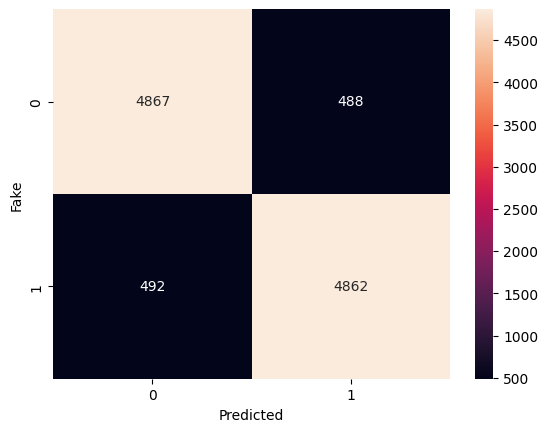

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Fake')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5355
           1       0.91      0.91      0.91      5354

    accuracy                           0.91     10709
   macro avg       0.91      0.91      0.91     10709
weighted avg       0.91      0.91      0.91     10709



In [ ]:
model.save("model_v1.h5")